# 03. 데이터 분석에서의 벡터

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib_inline.backend_inline
plt.rcParams.update({'font.size':14}) 

<br>

## 03.01 상관관계와 코사인 유사도

<br>

### 상관계수
#### **상관계수 : 두 변수 사이의 선형관계를 정량화한 수치. -1 ~ 1사이의 값을 가짐**
- 상관계수가 -1과 1사이에 존재하기 위하여 정규화가 필요

    1. 2개 변수의 평균중심화 : 각 데이터값에서 평균값을 뺌
    2. 평균중심화된 2개 벡터간 노름 곱으로, 2개 벡터의 내적을 나눔 : 측정 단위를 제거하고 상관계수 최대 크기를 [1]로 조정

$$\rho = \frac{\sum^n_{i=1}(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum^n_{i=1}(x_i -\bar{x})^2} \sqrt{\sum^n_{i=1}(y_i -\bar{y})^2}}$$

<br>

- $\tilde{x}$가 $x$를 평균중심화 한 벡터라고 할 때,
$$\rho = \frac{\tilde{x}^T \tilde{y}}{||\tilde{x}||\;\;||\tilde{y}||}$$

#### `np.corrcoef()`

In [3]:
a = np.random.randn(15)
b = np.random.randn(15)

In [4]:
np.corrcoef(a, b)

array([[ 1.        , -0.25344829],
       [-0.25344829,  1.        ]])

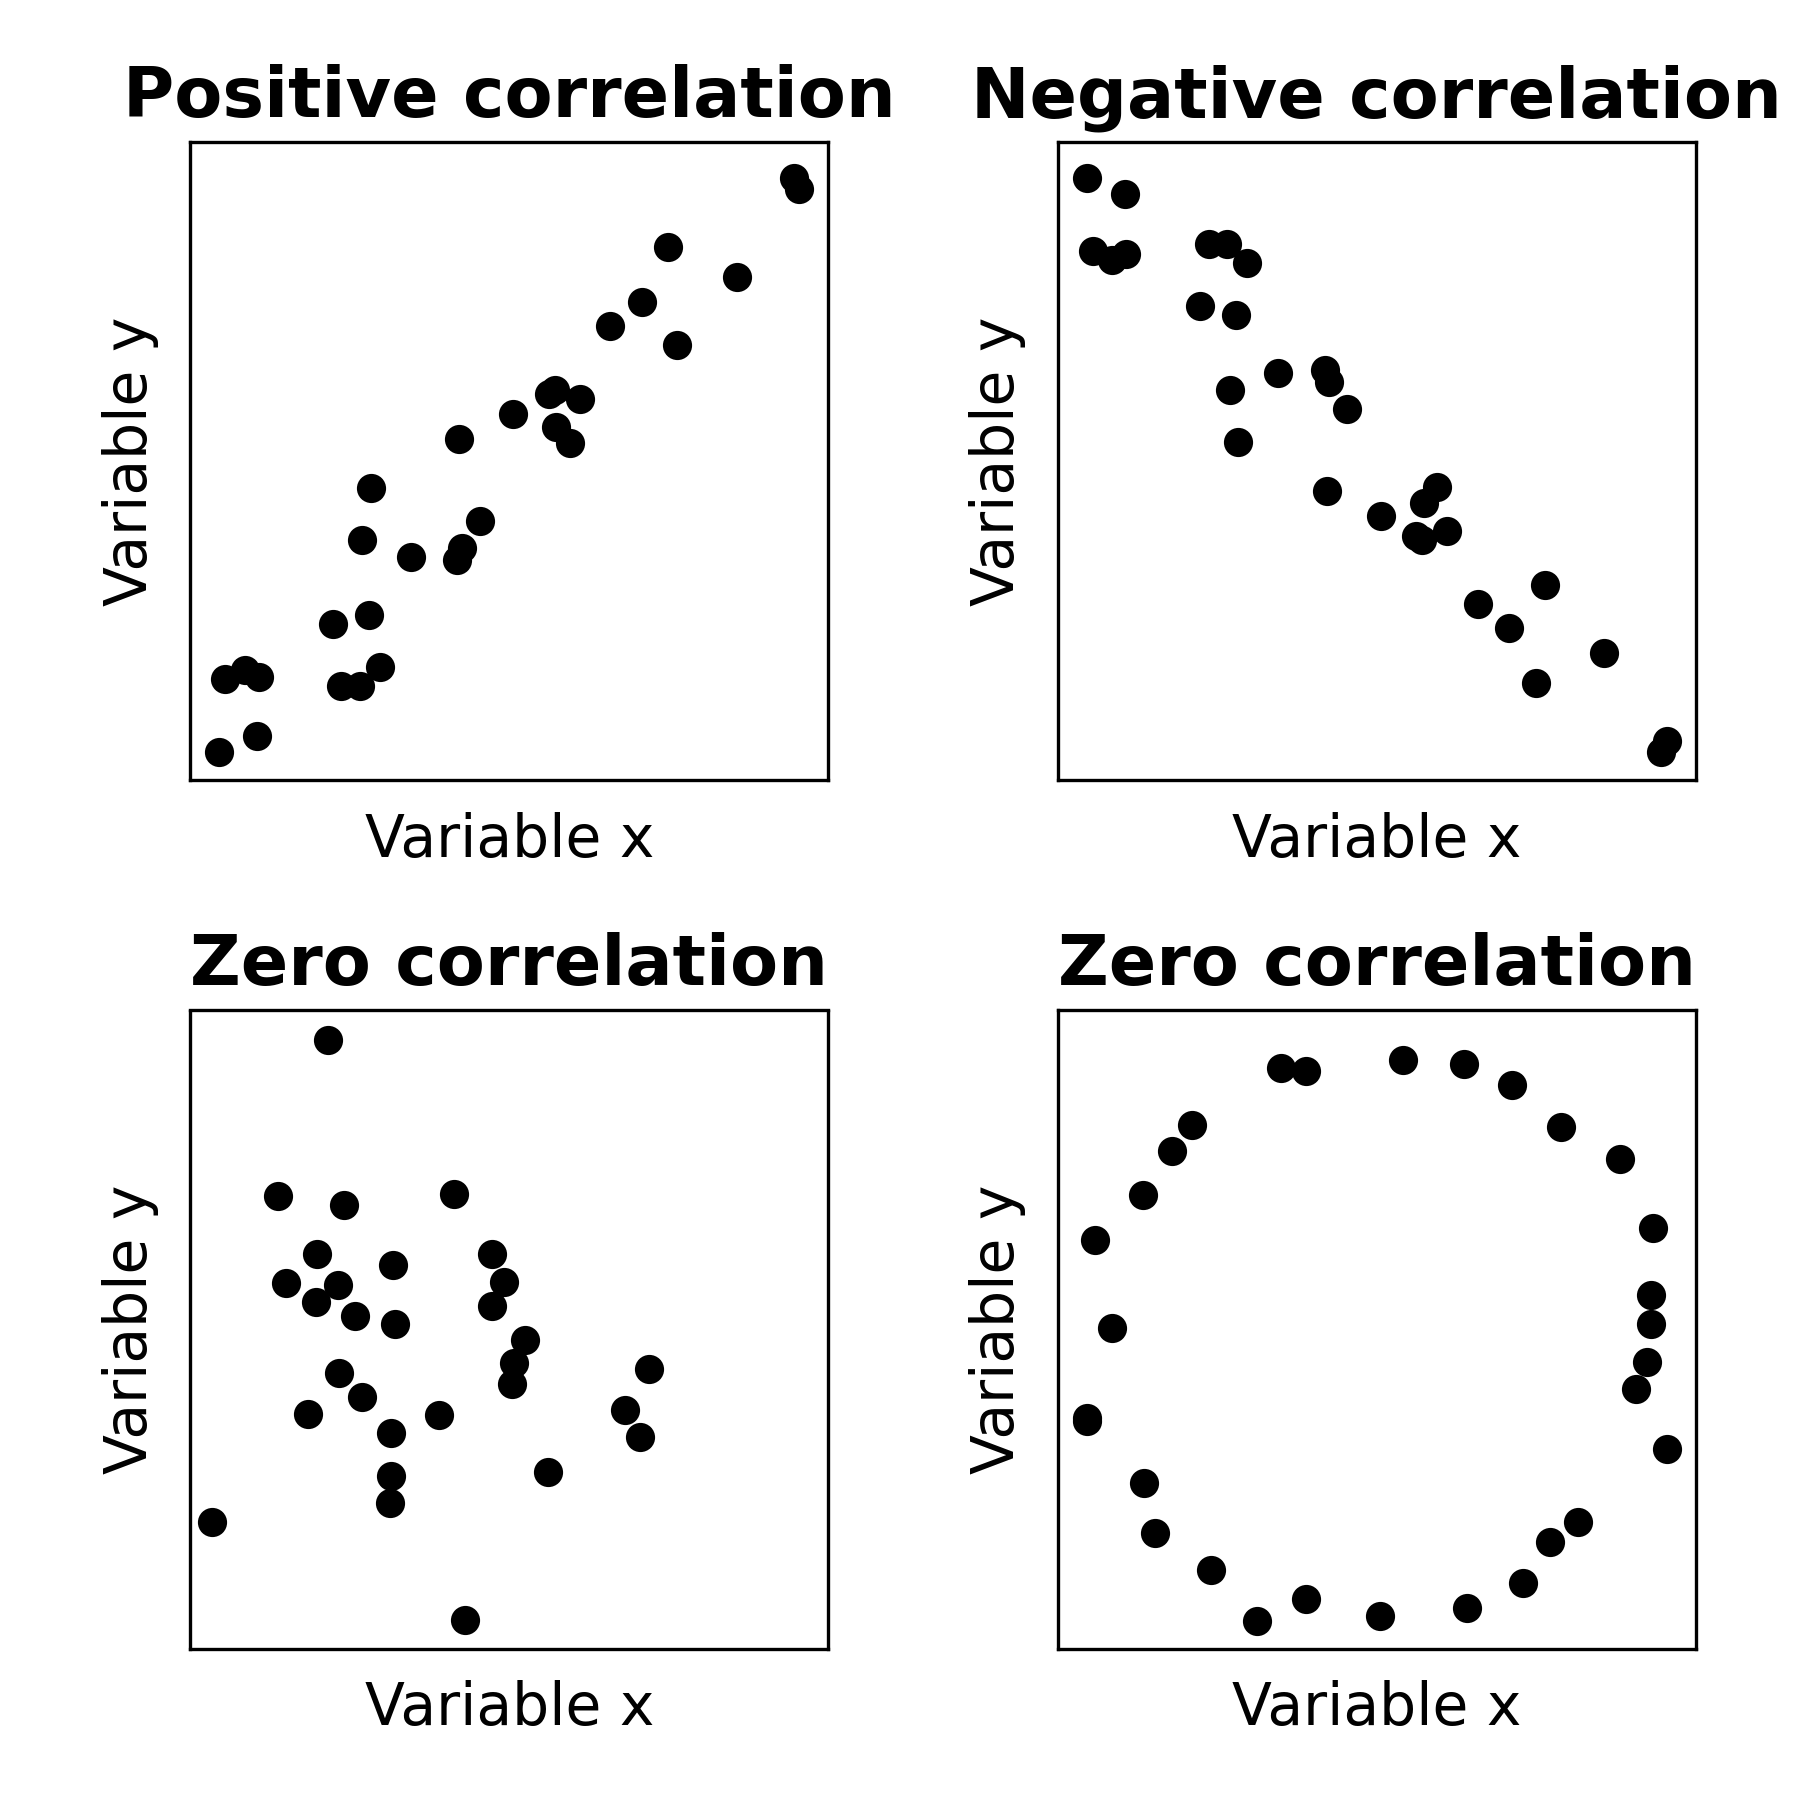

<br>

### 코사인 유사도 (cosine similarity)
- **정규화되지 않은 상관계수의 형태**


$$cos(\theta_{x, y}) = \frac{x^T y}{||x||\;\;||y||}$$

<br>

#### `sklearn.metrics.pairwise.cosine_similarity()` : 코사인 유사도

In [5]:
from sklearn.metrics.pairwise import cosine_similarity

In [6]:
cosine_similarity([a,b])

array([[ 1.        , -0.04937475],
       [-0.04937475,  1.        ]])

<br>

### 상관계수와 코사인 유사도
- **코사인 유사도와 상관계수 모두 내적을 기반으로 하는, 두 변수 사이의 선형 관계를 반영하는 지표**


<br>

#### 상관계수와 코사인 유사도의 비교
- 0 ~ 3까지의 정수들 (a)

    이 정수에 -50 ~ 50까지의 수를 더한 수 (b)와의 상관계수, 코사인 유사도 비교
    
    예) 1st loop : [0, 1, 2, 3] & [-50, -49, -48, -47]

In [7]:
a = np.arange(4,dtype=float)
offsets = np.arange(-50,51)

In [8]:
a, offsets

(array([0., 1., 2., 3.]),
 array([-50, -49, -48, -47, -46, -45, -44, -43, -42, -41, -40, -39, -38,
        -37, -36, -35, -34, -33, -32, -31, -30, -29, -28, -27, -26, -25,
        -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12,
        -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,
          2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
         41,  42,  43,  44,  45,  46,  47,  48,  49,  50]))

In [9]:
results = np.zeros((len(offsets),2))
results

for i in range(len(offsets)):
    results[i,:] = [np.corrcoef(a, a+offsets[i])[0][1], 
                    cosine_similarity([a, a+offsets[i]])[0][1]]

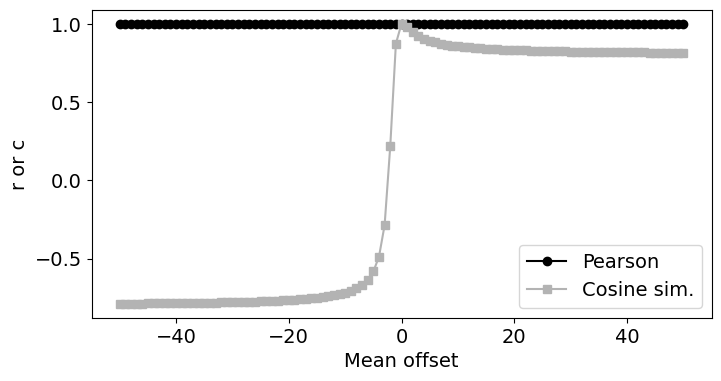

In [10]:
plt.figure(figsize=(8,4))
h = plt.plot(offsets,results)
h[0].set_color('k')
h[0].set_marker('o')
h[1].set_color([.7,.7,.7])
h[1].set_marker('s')

plt.xlabel('Mean offset')
plt.ylabel('r or c')
plt.legend(['Pearson','Cosine sim.'])
plt.show()

<br>

## 03.02. 시계열 필터링과 특징 탐지
### 특징 탐지
- **템플릿(커널, kernel)과 일치하는 특징을 가진 시계열 부분을 탐색**

    필터링된 결과는 또 다른 시계열이 되며, 이를 통해 신호의 특성이 커널의 특성과 얼마나 일치하는지 알 수 있음
- 매끄러운 변동, 날카로운 에지(edge), 특정 파형 모양 등과 같은 특정 기준에 최적화되도록 커널을 구성

### 특징 탐지 절차
1. 시계열을 특정 단위의 길이로 필터링 (커널은 일반적으로 전체 시계열보다 훨씬 짧음)
2. 필터링된 시계열과 커널 사이의 내적을 계산
3. **합성곱(Convolution) 과정 : 커널을 오른쪽으로 한 구간씩 이동시키면서 다른 신호 조각과 내적을 계산 $\rightarrow$ 필터링된 신호 생성**

<br>

<hr>

### 에지 검출기 예시
#### 커널 생성

In [11]:
kernel = np.array([-1,1])

#### 시계열 

In [12]:
signal = np.zeros(30)
signal[10:20] = 1

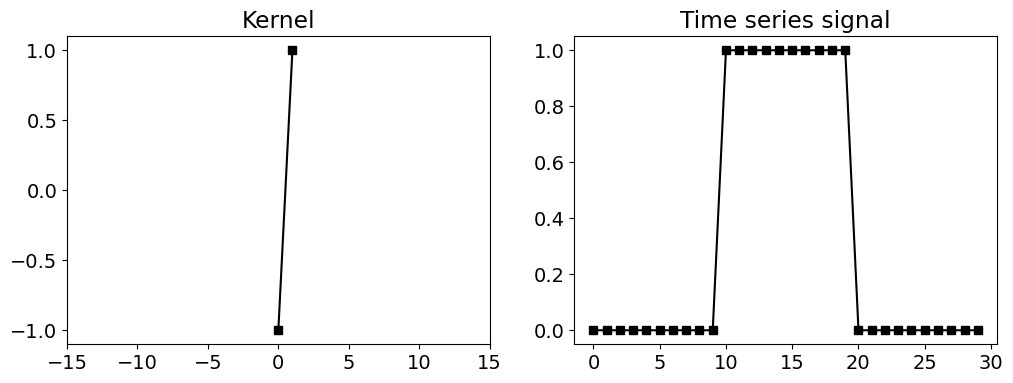

In [13]:
_,axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(kernel,'ks-')
axs[0].set_title('Kernel')
axs[0].set_xlim([-15,15])

axs[1].plot(signal,'ks-')
axs[1].set_title('Time series signal')

plt.show()

#### 합성곱 과정

In [14]:
featureMap = np.zeros(len(signal))

for t in range(1,len(signal)-1):
  featureMap[t] = np.dot(kernel,signal[t-1:t+1])

#### 합성곱 확인
- 신호가 평평할 때 0, 신호가 상승할 때 1, 신호가 하강할 때 -1을 반환하는 에지 검출기

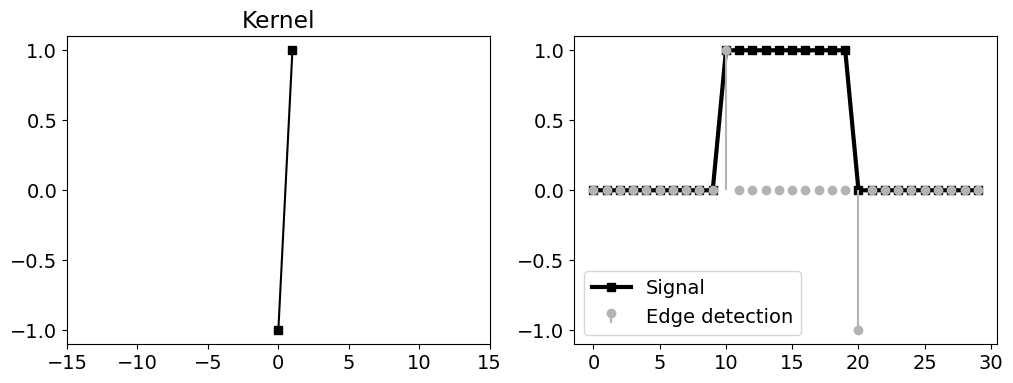

In [15]:
_,axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(kernel,'ks-')
axs[0].set_title('Kernel')
axs[0].set_xlim([-15,15])


axs[1].plot(signal,'ks-',label='Signal',linewidth=3)
markers,stemlines,_ = axs[1].stem(range(len(featureMap)),featureMap,
                                  basefmt=' ',linefmt='',markerfmt='o',
                                  label='Edge detection')

plt.setp(stemlines,'color',[.7,.7,.7])
plt.setp(markers,'color',[.7,.7,.7])

axs[1].legend()
plt.show()

<br>

### 저주파 (low-pass) 필터링

#### 가우스 커널 생성
- 정규분포의 난수로 구성된 커널

    (커널 합이 1이 되도록 조정)

In [16]:
kernel = np.array([0,.1,.3,.8,1,.8,.3,.1,0])
kernel = kernel / np.sum(kernel)

In [17]:
Nkernel = len(kernel)
halfKrn = Nkernel//2

#### 시그널 

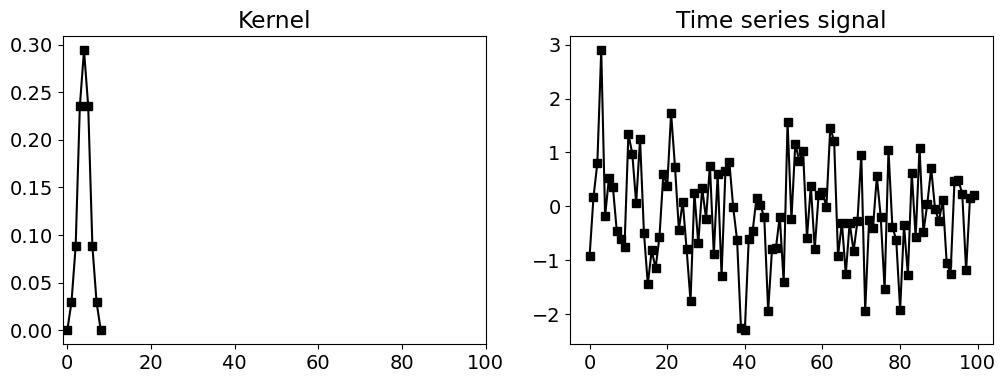

In [18]:
Nsignal = 100
timeseries = np.random.randn(Nsignal)

_,axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(kernel,'ks-')
axs[0].set_title('Kernel')
axs[0].set_xlim([-1,Nsignal])

axs[1].plot(timeseries,'ks-')
axs[1].set_title('Time series signal')

plt.show()

#### 합성곱
- 필터링된 신호는 원래 신호의 매끄러운 형태이며, 이를 저주파 필터링이라고 함

In [19]:
filtsig = timeseries.copy()

for t in range(halfKrn+1,Nsignal-halfKrn):
  filtsig[t] = np.dot(kernel,timeseries[t-halfKrn-1:t+halfKrn])

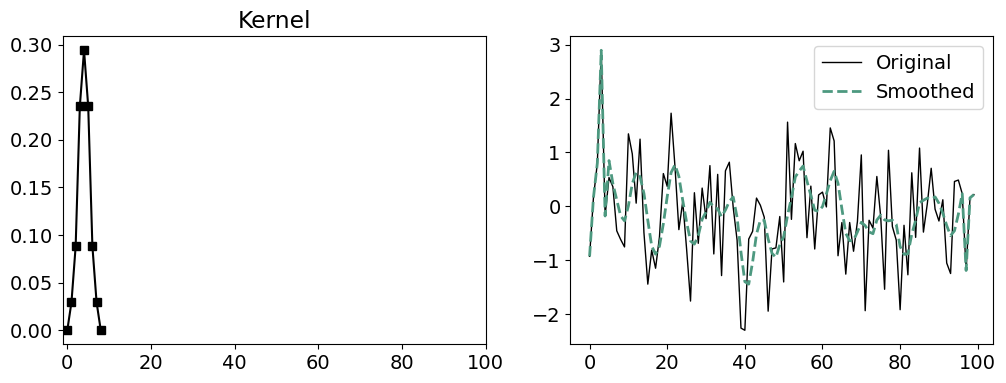

In [20]:
_,axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(kernel,'ks-')
axs[0].set_title('Kernel')
axs[0].set_xlim([-1,Nsignal])

axs[1].plot(timeseries,color='k',label='Original',linewidth=1)
axs[1].plot(filtsig,'--',color=[.3, .6, .5],label='Smoothed',linewidth=2)
axs[1].legend()

plt.show()

<br>

### 가우스 커널 변형

- 가우스 커널 중앙의 1값을 -1로 바꾸고, 커널에 중앙 평균화를 적용

In [21]:
kernel = np.array([0,.1,.3,.8,-1,.8,.3,.1,0])
kernel /= np.sum(kernel)
kernel -= np.mean(kernel)

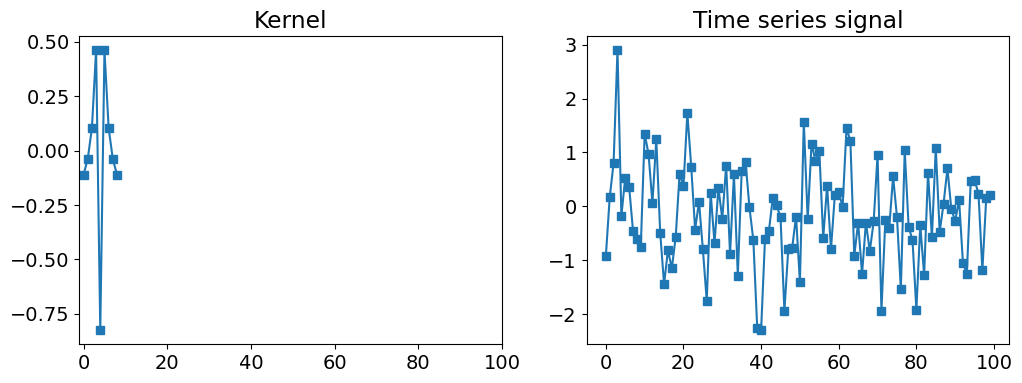

In [22]:
_,axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(kernel,'s-')
axs[0].set_title('Kernel')
axs[0].set_xlim([-1,Nsignal])

axs[1].plot(timeseries,'s-')
axs[1].set_title('Time series signal')
plt.show()

#### 합성곱 과정

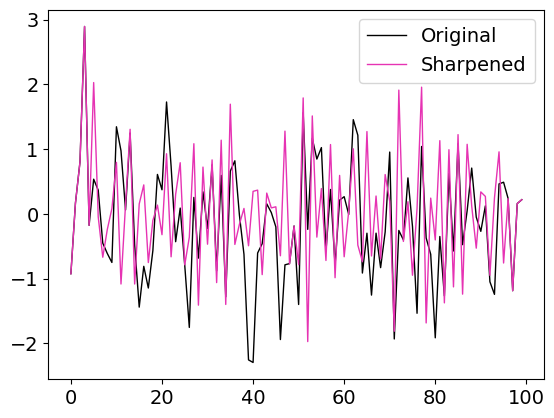

In [23]:
filtsig2 = timeseries.copy()
for t in range(halfKrn+1,Nsignal-halfKrn):
  filtsig2[t] = np.dot(kernel,timeseries[t-halfKrn-1:t+halfKrn])

plt.plot(timeseries,color='k',label='Original',linewidth=1)
plt.plot(filtsig2,color=[.9,.2,.7],label='Sharpened',linewidth=1)
plt.legend()
plt.show()

<br>

## 03.03. k-평균 클러스터링
- 그룹 중심까지의 거리를 최소화하도록, 다변량 데이터를 상대적으로 적은 수($k$)의 그룹 또는 범주로 분류하는 비지도 학습 기법

<br>

### k-평균 클러스터링 구현

#### 1. 무작위로 $k$개의 클러스터 중심을 초기화
- $k$는 초 매개변수


In [24]:
k=3

In [30]:
A = [  1, 1 ]
B = [ -3, 1 ]
C = [  3, 3 ]

nPerClust = 50
blur = 1

a = [ A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur ]
c = [ C[0]+np.random.randn(nPerClust)*blur , C[1]+np.random.randn(nPerClust)*blur ]

data = np.transpose( np.concatenate((a,b,c),axis=1) )

In [31]:
ridx = np.random.choice(range(len(data)), k, replace=False)

In [32]:
centroids = data[ridx, :]
centroids

array([[ 1.91442649,  1.78132918],
       [-3.92841347,  0.25345507],
       [ 2.25688809,  2.94254601]])

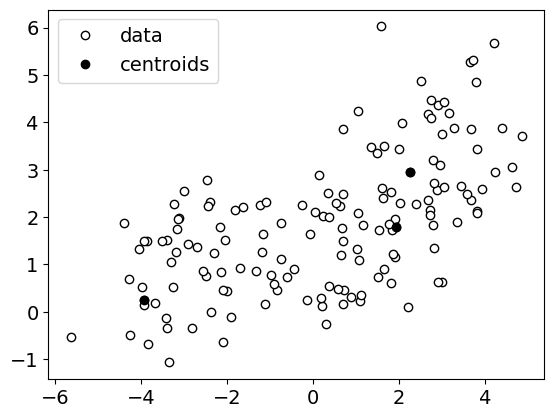

In [33]:
plt.plot(data[:, 0], data[:, 1], 'ko', markerfacecolor='w', label='data')
plt.plot(centroids[:, 0], centroids[:, 1], 'ko', label='centroids')
plt.legend()
plt.show()

<br>

#### 2. 각 데이터 관측치와 각 중심 사이의 유클리드 거리를 계산
- **유클리드 거리 : 데이터 관측치 $i$에서 중심 $j$까지의 거리**


$$\delta_{i, j} = \sqrt{(d^x_i- c^x_j)^2 + (d^y_i + c^y_j)^2}$$

#### `sklearn.metrics.pairwise.euclidean_distances()`

In [34]:
from sklearn.metrics.pairwise import euclidean_distances

In [35]:
dists = np.zeros((data.shape[0], k))

for j, d in enumerate(data):
    for i, c in enumerate(centroids):   
        dists[j][i] = euclidean_distances([c, d])[0][1]

#### 3. 각 데이터 관측치를 가장 까까운 중심의 그룹에 할당

In [36]:
group_idx = np.argmin(dists, axis=1)
group_idx

array([0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
       2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0,
       2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2], dtype=int64)

#### 4. 각 중심을 해당 중심에 할당된 모든 데이터 관측치의 평균으로 갱신

In [37]:
centroids

array([[ 1.91442649,  1.78132918],
       [-3.92841347,  0.25345507],
       [ 2.25688809,  2.94254601]])

In [38]:
centroids_update = centroids.copy()

for ki in range(k):
    centroids_update[ki, :] = (np.mean(data[group_idx==ki, 0]), np.mean(data[group_idx==ki, 1]))

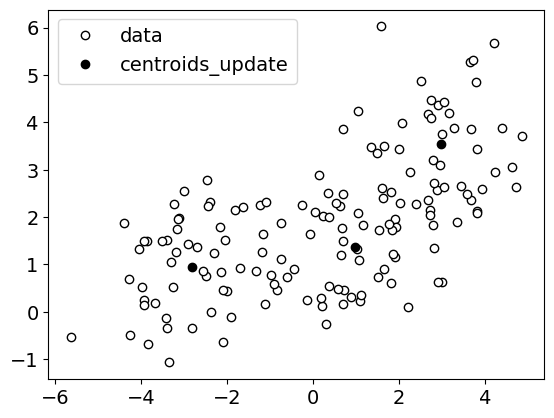

In [39]:
plt.plot(data[:, 0], data[:, 1], 'ko', markerfacecolor='w', label='data')
plt.plot(centroids_update[:, 0], centroids_update[:, 1], 'ko', label='centroids_update')
plt.legend()
plt.show()

#### 5. 수렴 기준을 만족할 떄까지 또는 $N$회 까지 2~4단계를 반복

<br>

### k-평균 클러스터링

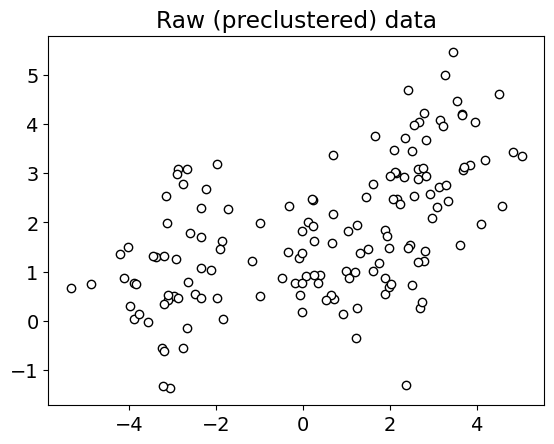

In [40]:
nPerClust = 50
blur = 1

A = [  1, 1 ]
B = [ -3, 1 ]
C = [  3, 3 ]

a = [ A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur ]
c = [ C[0]+np.random.randn(nPerClust)*blur , C[1]+np.random.randn(nPerClust)*blur ]

data = np.transpose( np.concatenate((a,b,c),axis=1) )

plt.plot(data[:,0],data[:,1],'ko',markerfacecolor='w')
plt.title('Raw (preclustered) data')

plt.show()

In [41]:
k = 3 

ridx = np.random.choice(range(len(data)),k,replace=False)
centroids = data[ridx,:]

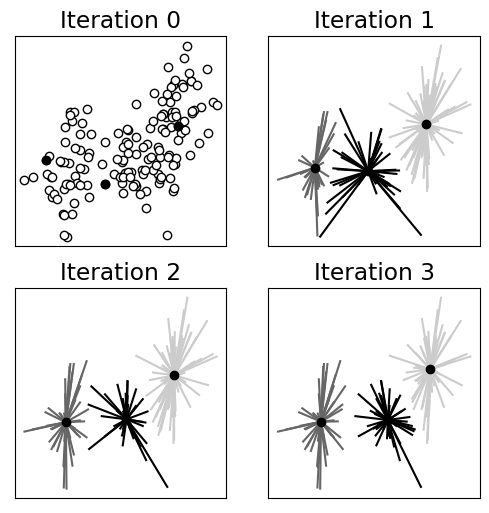

In [42]:
fig,axs = plt.subplots(2,2,figsize=(6,6))
axs = axs.flatten()
lineColors = [ [0,0,0],[.4,.4,.4],[.8,.8,.8] ]#'rbm'

axs[0].plot(data[:,0],data[:,1],'ko',markerfacecolor='w')
axs[0].plot(centroids[:,0],centroids[:,1],'ko')
axs[0].set_title('Iteration 0')
axs[0].set_xticks([])
axs[0].set_yticks([])

for iteri in range(3):
    
  dists = np.zeros((data.shape[0],k))
  for ci in range(k):
    dists[:,ci] = np.sum((data-centroids[ci,:])**2,axis=1)
        
  groupidx = np.argmin(dists,axis=1)
    
  for ki in range(k):
    centroids[ki,:] = [ np.mean(data[groupidx==ki,0]), np.mean(data[groupidx==ki,1]) ]
  

  for i in range(len(data)):
    axs[iteri+1].plot([ data[i,0],centroids[groupidx[i],0] ],[ data[i,1],centroids[groupidx[i],1] ],color=lineColors[groupidx[i]])
  axs[iteri+1].plot(centroids[:,0],centroids[:,1],'ko')
  axs[iteri+1].set_title(f'Iteration {iteri+1}')
  axs[iteri+1].set_xticks([])
  axs[iteri+1].set_yticks([])

plt.show()